Problem and data obtained from Topcoder: https://goo.gl/Z2yAc1

Data: expressions_example.csv (FPKM-normalized gene expression data); copynumber_example.csv (log-2 scaled ratio between tumor and normal tissue); mutations_example.csv (boolean matrix indicating whether the gene is mutated or not; groundtruth_example.csv (a ground truth table containing when a sample's myeloma progressed and how long they were observed for)

Goal: Create an algorithm that can rank-order patients based on when their myeloma will progress.

# Preliminary Work

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines as sa
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

os.chdir("/Users/arudhir/Desktop/datascience/gen/data-science")

In [2]:
%load_ext rpy2.ipython
%matplotlib notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
exp_ = pd.read_csv("expressions_example.csv")
cop_ = pd.read_csv("copynumber_example.csv")
mut_ = pd.read_csv("mutations_example.csv")
labels_ = pd.read_csv("groundtruth_example.csv")
tumor_ = (2**cop_) * exp_
# cop = log2(tumor_exp/avg_exp) --> tumor_exp = 2^cop * avg_exp
# Double check this just to make sure you didn't do any dumb log mistakes
# Added way later - will be treated similarly to exp

Let's take a peek at the data to see what we're dealing with.

Some preliminary information about the data:
* 332 patients
* 18898 genes
* No controls given
* exp_ are RNA-Seq values normalized by FPKM (Fragments Per Kilobase per Million of reads) — MEASURES EXPRESSION NOT TRANSCRIPTION BECAUSE OF THE FPKM NORMALIZATION)
* cop_ values represent the log-2 scaled ratio between tumor and normal tissue. 0 means no copy change, negative values are deletions, and positive values are amplifications.

In [4]:
display(exp_.head())
display(cop_.head())
display(mut_.head())
display(labels_)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,58.17320,6.495410,0.008073,9.211960,9.526840e-02,0.0,0.0,7.610780,0.0,21.3624,...,4.29543,1.99342,2.05187,4.28177,6.77533,0.582515,4.03227,3.86044,10.00660,8.77633
2,12.61650,1.366810,0.009984,0.189634,0.000000e+00,0.0,0.0,0.011428,0.0,27.5223,...,10.50690,18.24670,1.79673,4.65033,9.97783,0.438181,4.12738,1.80705,7.10719,12.76300
3,36.24930,4.617980,0.016465,3.155810,2.590000e-93,0.0,0.0,0.024333,0.0,41.1404,...,3.64073,1.20923,3.52182,5.26011,9.29593,0.236348,6.02189,4.70723,22.19530,15.51290
4,4.74214,0.533191,0.006551,0.721501,5.308500e-02,0.0,0.0,0.015689,0.0,20.1478,...,3.38063,8.35660,2.54064,7.28599,11.99610,0.313813,4.52186,7.45951,10.41090,14.90610


,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,0.5408,0.5408,-0.0313,-0.0308,-0.0308,-0.0308,-0.0383,-0.0422,0.5453,-0.0305,...,0.5301,-0.0313,-0.0238,-0.0238,0.5453,-0.0285,-0.0285,0.0067,0.4032,-0.5906
1,0.5482,0.5482,0.0020,-0.0222,-0.0222,-0.0222,-0.0089,-0.0216,0.0067,-0.0124,...,0.5539,-0.0550,0.0268,0.0268,0.0135,-0.0133,-0.0133,-0.0308,-0.0295,-0.0410
2,0.4951,0.4951,-0.0773,-0.0791,-0.0791,-0.0791,-0.0357,-0.9072,0.4844,-0.0387,...,0.7533,-0.0773,-0.0865,-0.0865,0.4844,-0.0076,-0.0076,0.4471,-0.0289,-0.1032
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0177,0.0177,-0.0070,-0.9895,-0.9895,-0.9895,-0.0025,-0.0203,-0.0074,-0.9930,...,-0.0045,-0.0070,-0.1334,-0.1334,-0.0074,-0.0298,-0.0298,-0.0130,-0.0174,-0.0298


,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,TP,TO
0,692.0,692.0
1,NaN,1212.0
2,NaN,1185.0
3,218.0,1118.0
4,NaN,1134.0
5,1079.0,1079.0
6,244.0,580.0
7,521.0,564.0
8,NaN,1034.0
9,118.0,118.0


**Initial ideas**:
1. The relative copy number data can be used to detect anomalies relative to both the other genes in the patient **and** across the same gene in all the patients; one finds potential oncogenes/tumor suppressor genes, the other finds unique differences between each patient that can be utilized to help us ultimately rank them.
2. Mutation data can be used to screen genes by: looking at mutations that exist across a significant portion of patients; looking at mutations that are unique to a patient compared to the others (i.e., genes that show significant variance between samples).
3. LASSO and Random Forests to feature select
4. Survival analysis and AFT to predict lifetimes

# Cleaning/Formatting the Data


In [5]:
exp = exp_.add_suffix("_e")  # avg_exp
cop = cop_.add_suffix("_c")
mut = mut_.add_suffix("_m")
tumor = tumor_.add_suffix("_t")

labels = labels_.dropna(axis=0, how='all')
# Adds a boolean column to indicate whether the myeloma has progressed or not
labels['P'] = ~np.isnan(labels['TP'])

We have to decide how to handle the missing expression data. I think there is a potential to make more intelligent imputation choices by using the rel. copy number data across patients and genes to scale it. But this sounds complicated, convoluted, and statistically dubious, so for now, let's just get rid of all NaN values. 

In [6]:
exp = exp.dropna(axis=0, how='all')
cop = cop.dropna(axis=0, how='all')
mut = mut.dropna(axis=0, how='all')
tumor = tumor.dropna(axis=0, how='all')

Let's scale the expression data too. There are more complicated schemes to feature scale microarray data (a least-squares approach is explored here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4028811/) but again for now, simplicity.

In [7]:
from functools import wraps
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer

def transformWrapper(transformer):
    '''
    Wraps an sklearn transformer so that transformations retain indices and column names.
    TODO: Try and make compatible with sklearn.pipeline
    '''
    def fitTransformKeepNames(data, *args, **kwargs):
        idx, col = data.index, data.columns
        ret = pd.DataFrame(transformer(*args, **kwargs).fit_transform(data))
        ret.index, ret.columns = idx, col
        return ret
    return fitTransformKeepNames
        

def FPKMtoTPM(data):
    '''
    Converts FPKM-normalized data to TPM-normalized data. Extensive literature saying this leads to better comparisons.
    Refer to notes above.
    
    Note: Does not create a copy
    '''
    for i in range(data.shape[0]):
        s = np.sum(data.iloc[i, :])
        data.iloc[i, :] = (data.iloc[i, :] / s) * 1000000

    return data


FPKMtoTPM(exp);
FPKMtoTPM(tumor);
# exp = transformWrapper(MinMaxScaler)(exp)

The tumor and avg expression data is now in TPM (Transcripts per Kilobase Million) - refer to the literature in the notes section. In short, TPM is better suited for comparing values between samples.

Let's get a sense of how some of the genes look like.

In [8]:
import scipy.stats as stats

display(stats.describe(exp['A2ML1_e']))
display(stats.describe(exp['A1CF_e']))
display(stats.describe(exp['A4GALT_e']))
display(stats.describe(exp['A1BG_e']))

DescribeResult(nobs=275, minmax=(0.0, 0.22343147840641822), mean=0.0026149309839028885, variance=0.00028336340048038347, skewness=9.952778841360024, kurtosis=114.56459243606605)

DescribeResult(nobs=275, minmax=(0.0, 0.27917595909391496), mean=0.057885104524224809, variance=0.0029030938040609379, skewness=1.1539706702089687, kurtosis=1.241792363093019)

DescribeResult(nobs=275, minmax=(0.0, 25.289223947664652), mean=1.2054198777000293, variance=10.876853302058361, skewness=4.815989565803562, kurtosis=26.611521120667902)

DescribeResult(nobs=275, minmax=(0.0, 320.0881171481717), mean=46.771658594649004, variance=2483.1790818933132, skewness=1.665391823007341, kurtosis=4.684870953426343)

Variance is something that we can filter based off of. Also, we'll need to find what distribution (nbinom or gamma) the data follows.

*TODO: Find out when variance stabilization is needed and how to do it*

*TODO: Make QQ plots*

TPM alone is used in some papers for comparing patients and genes, so for now, let's just go with it.

Now we have nice and neat preprocessed data. Now it's time to model and graph things.

# Feeling the Data



Let's roll around with our data for a little bit.

## Principal Component Analysis

Related literature worth reading: http://journals.sagepub.com/doi/full/10.1016/S1535-5535-04-00033-4

Let's first project our data onto 1, 2, and 3 dimensions and see if we can find any clusters. First let's prepare our data so it can be easily used by Seaborn.

In [10]:
from sklearn.decomposition import PCA


def transformWrapperDecomp(transformer):
    '''
    Wraps decomposition functions; keeps indices
    TODO: Does not fix the indices - figure out why
    '''
    def fitTransformKeepNames(data, *args, **kwargs):
        idx = data.index
        ret = pd.DataFrame(transformer(*args, **kwargs).fit_transform(data))
        ret.index = idx
        return ret
    return fitTransformKeepNames


def formatPCA(data, n_components):
    '''
    Add column names, combine with labels, add a zeros column for convenience
    '''
    data_pca = transformWrapperDecomp(PCA)(data, n_components=n_components)
    data_pca = data_pca.rename(columns={0: "E1", 1: "E2", 2: "E3"})
    data_pca['Progressed'] = labels.P
    data_pca['Zeros'] = np.zeros(data_pca.shape[0])
    return data_pca

exp_pca = formatPCA(exp, n_components=3)
tumor_pca = formatPCA(tumor, n_components=3)


def getProgressedAndCensored(data):
    '''
    Return two dataframes, containing those who progressed and those who did not progress. Progressed has the time to event concatenated.
    '''
    mask = (data.Progressed == True)
    data_prog = data[mask]
    # for Jupyter; labels.TP[mask] works just fine in Hydrogen
    data_prog['Time'] = labels.TP[mask.index].dropna()
    data_noprog = data[~mask]
    return(data_prog, data_noprog)

exp_pca_prog, exp_pca_noprog = getProgressedAndCensored(exp_pca)
tumor_pca_prog, tumor_pca_noprog = getProgressedAndCensored(tumor_pca)

We have the top three principal components given by PCA. Let's visualize the first one. There are two main populations in our data: those who progressed, and those who didn't. We are going to assume that those who progressed have similarities with each other, and likewise for those who didn't. Let's see what a 1D scatterplot looks like when they are separated, and together, differentiated by color.

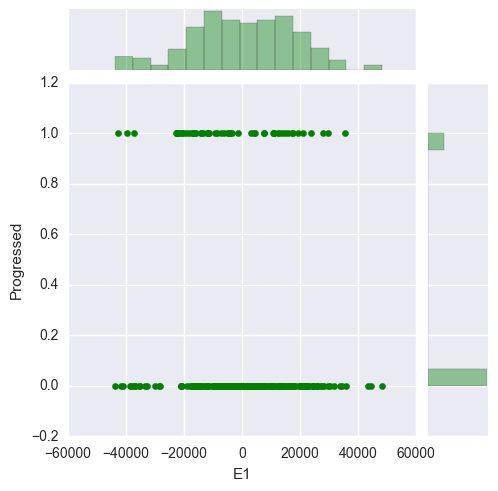

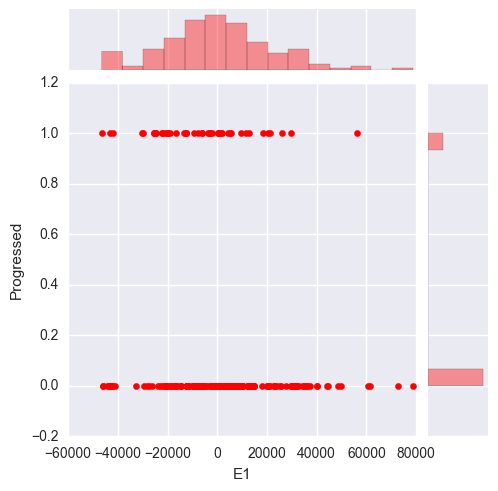

In [11]:
jp1 = sns.jointplot(x=exp_pca["E1"], y=exp_pca["Progressed"],
                    marginal_kws=dict(bins=15),
                    stat_func=None, size=5, color='g')

jp2 = sns.jointplot(x=tumor_pca["E1"], y=tumor_pca["Progressed"],
                    marginal_kws=dict(bins=15),
                    stat_func=None, size=5, color='r')

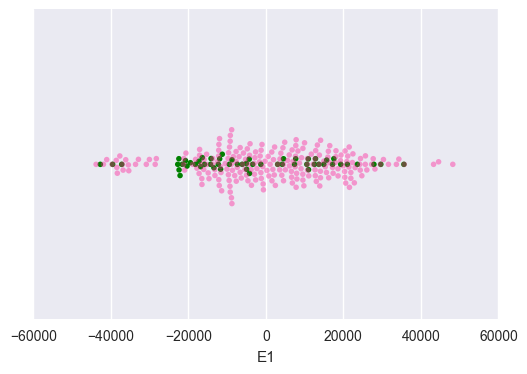

In [12]:
s1 = sns.swarmplot(x=exp_pca_prog["E1"], color="green", size=4)
sns.swarmplot(x=exp_pca_noprog["E1"], color="#ff1493", size=4, alpha=0.4, ax=s1)

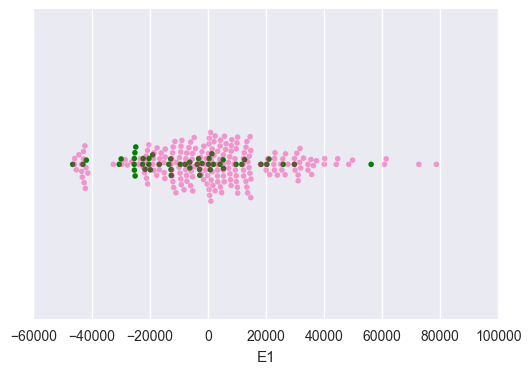

In [13]:
s2 = sns.swarmplot(x=tumor_pca_prog["E1"], color="green", size=4)
sns.swarmplot(x=tumor_pca_noprog["E1"], color="#ff1493", size=4, alpha=0.4, ax=s2)

The tumor expression values seem to show a bigger distinction. Let's keep exploring.

Also, there is one more thing we can do — we can try and fit a gamma distribution to the first component and get a feel as to whether or not our data is gamma distributed.

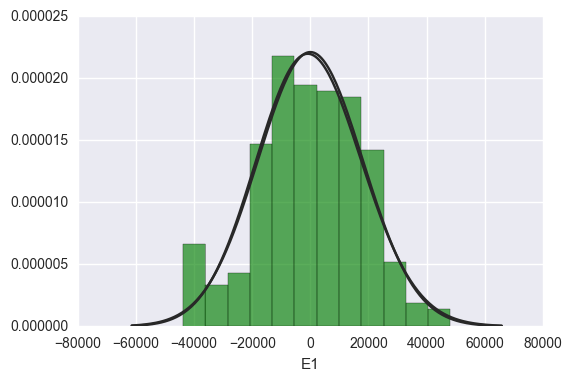

In [14]:
fit_gamma_exp = sns.distplot(exp_pca["E1"], kde=False, fit=stats.gamma, color="green")
sns.distplot(exp_pca["E1"], kde=False, fit=stats.norm, color="green")

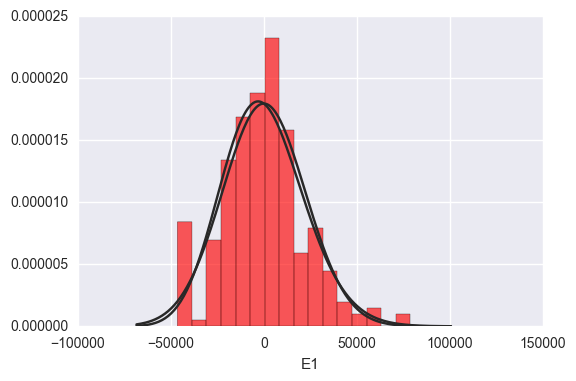

In [15]:
fit_gamma_tumor = sns.distplot(tumor_pca['E1'], kde=False, fit=stats.gamma, color='red')
sns.distplot(tumor_pca['E1'], kde=False, fit=stats.norm, color='red')

Cool, both of them fit with a gamma and normal distribution; since they are approximately normal, we can safely calculate meaningful Pearson correlation coefficients (later).

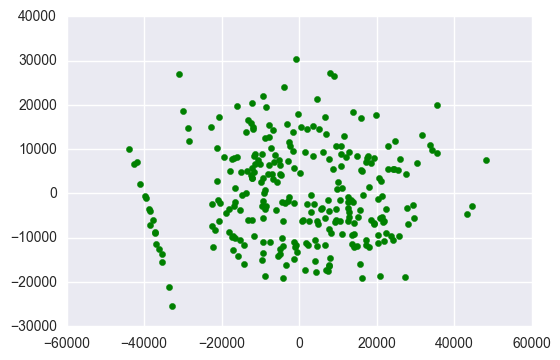

In [16]:
import matplotlib.cm as cm # http://matplotlib.org/api/cm_api.html

f, ax = plt.subplots()
ax = ax.scatter(x=exp_pca["E1"], y=exp_pca["E2"], color='g')

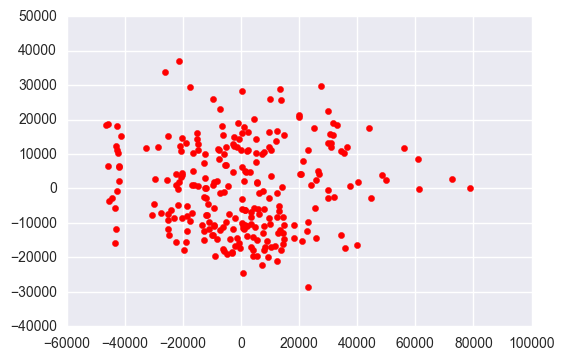

In [17]:
f, ax = plt.subplots()
ax = ax.scatter(x=tumor_pca["E1"], y=tumor_pca["E2"], color='r')

Let's see if there is more structure with regards to progression time.

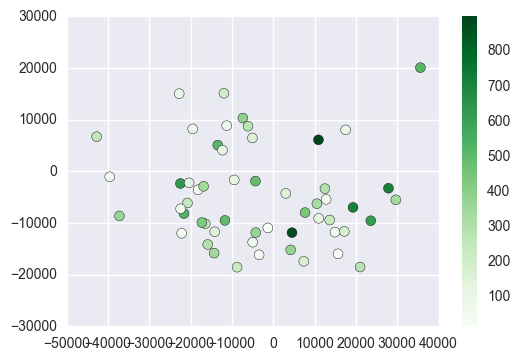

In [18]:
f, ax = plt.subplots()
ax = scatter(x=exp_pca_prog["E1"], y=exp_pca_prog["E2"], c=exp_pca_prog["Time"], s=50, cmap=cm.get_cmap(name="Greens"))
plt.colorbar(ax)

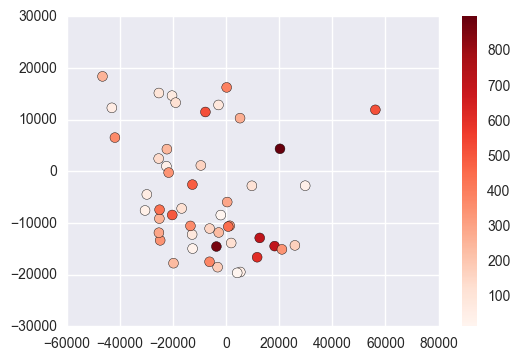

In [19]:
f, ax = plt.subplots()
ax = scatter(x=tumor_pca_prog["E1"], y=tumor_pca_prog["E2"], c=tumor_pca_prog["Time"], s=50, cmap=cm.get_cmap(name="Reds"))
plt.colorbar(ax)

The tumor data again seems to show some evidence of small, equally colored clusters. Once we look at clustergrids (heatmaps with a dendrogram), relationships might become more lucid.

In [20]:
# Takes too long to render
if 1==0:
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs=exp_pca["E1"], ys=exp_pca["E2"], zs=exp_pca["E3"], c='green')

# Classification

One attempt out of many to make a classifier. To relate this to the problem — it makes sense that patients can be ranked by their probability of getting classified as "progressed".

Before we do all that, we'll need to assign X and y variables.

## Random Forest + Logistic Regression

In [22]:
def alignData(df1, df2):
    '''
    Create dataframes that have the same row indices (same samples)
    Args:
        df1 numpy ndarray; a dict with pandas.Series, arrays, constants, or list-like values; pandas.DataFrame
        df2 numpy ndarray; a dict with pandas.Series, arrays, constants, or list-like values; pandas.DataFrame
    Return: A tuple of DataFrames with the same row indices.

    Also tries to be fancy with exception handling.
    '''
    if not isinstance(df1, pd.DataFrame):
        df1 = pd.DataFrame(df1) # There is not a scope issue because df1 and df2 are passed parameters.
    if not isinstance(df2, pd.DataFrame):
        df2 = pd.DataFrame(df2)

    index = (df1.index & df2.index)
    ret1 = df1.loc[index, :]
    ret2 = df2.loc[index, :]
    return (ret1, ret2)

X_e, y_e = alignData(exp, labels)
y_e = np.ravel(y_e.P) # for sklearn

X_t, y_t = alignData(tumor, labels)
y_t = np.ravel(y_t.P)

### Nested Cross-Validation

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, cross_val_predict, validation_curve, RandomizedSearchCV

In [26]:
def nestedCrossValidation(X, y, pipeline, param_distributions, scoring, outer, inner):
    '''
    Estimates generalization error of the underlying model and its hyper-parameter search using k-fold stratified cross validation for both the inner and outer validations and prints out 10 scores.

    Params:
        X, y : Data and associated labels
        pipeline: Metaestimator generated from sklearn.pipeline.Pipeline - has the sequence of transforms and fits the estimator to the data at the end
        param_distributions : Dictionary with parameters names (string) as keys and distributions of parameters to try.
        scoring : One of sklearn's scoring functions
        outer, inner: cross-validators

    Outputs:
        Cross-validation scores for each outer fold.
        TODO: Find a way to print out the optimal parameters in each fold so we can examine stability of the hyperparameters as well

    Takes about 30 seconds per fold; so a 10-fold inner and outer cross-validation: 10 minutes.
    '''
    rs = RandomizedSearchCV(
        estimator=pipe, param_distributions=param_distributions, verbose=1, scoring='roc_auc', cv=inner)
    rs.fit(X, y)
    scores = cross_val_score(rs, X, y, cv=outer)
    print("Cross validation scores: {}".format(scores) + '\n' + "Best hyper-parameter score: {}".format(
        rs.best_score_) + "\n" "Optimized parameters: {}".format(rs.best_params_) + "\n")
    return ((rs.best_score_, rs.best_params_), scores)

rf_feat_imp = RandomForestClassifier(criterion='entropy')
feat_selection = SelectFromModel(rf_feat_imp)
pipe = Pipeline([('fs', feat_selection), ('fm', LogisticRegression())])
params = {
    'fs__estimator__n_estimators': np.arange(1, 100),
    'fs__estimator__min_samples_split': np.arange(2, 51),
    'fm__C': 10. ** np.arange(-3, 3)
}

outer = StratifiedKFold(n_splits=5)
inner = StratifiedKFold(n_splits=5)

In [ ]:
scores_e, best_scores_e, best_params_e = nestedCrossValidation(
    X_e, y_e, pipe, params, 'roc_auc', outer, inner
)  # Cross validation scores: [ 0.46428571  0.63095238  0.8452381   0.70238095  0.79166667  0.60119048 0.61111111  0.76388889  0.68055556  0.63194444] — seems unstable.

In [ ]:
scores_t, best_scores_t, best_params_t = nestedCrossValidation(
    X_t, y_t, pipe, params, 'roc_auc', outer, inner
)  # scores_t = array([ 0.57027027,  0.48918919,  0.37297297,  0.74444444,  0.53703704]) - also unstable scores

Cross-validation scores show high variance - indicating instability of hyper-parameters. This warrants further investigation. 

Let's visually look at how this algorithm performs with a validation curve; doing a learning curve doesn't matter since we don't have the means to collect more data

### Validation Curve

<module 'matplotlib.pyplot' from '/Users/arudhir/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/Users/arudhir/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

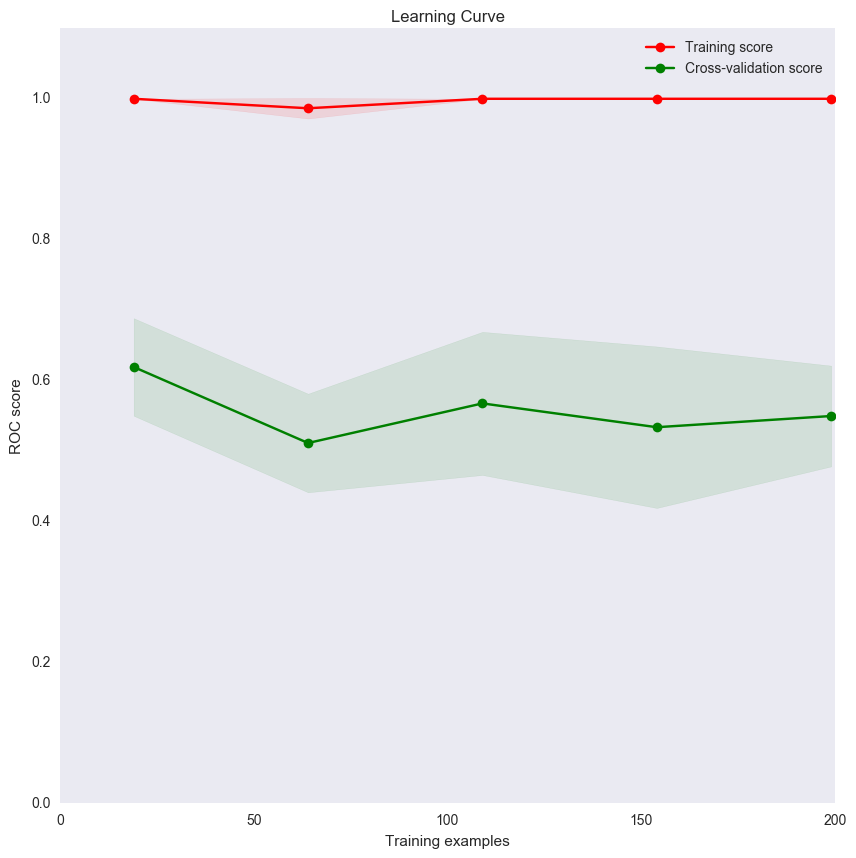

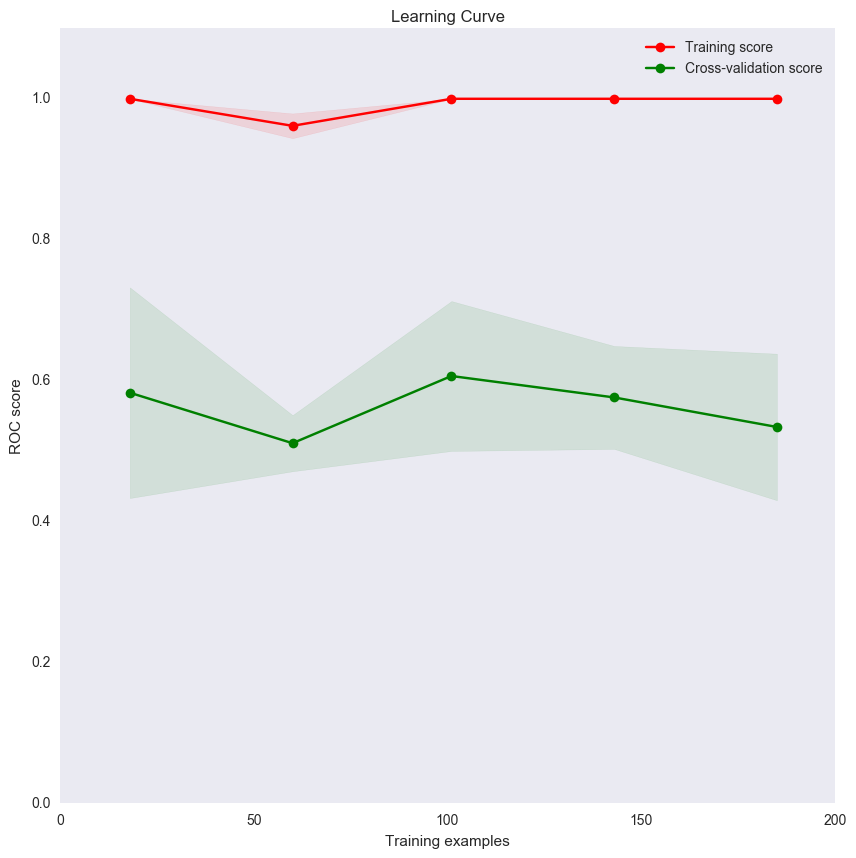

In [27]:
from sklearn.model_selection import validation_curve, learning_curve

def plotLearningCurve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    '''
    Taken from an sklearn example
    '''
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, train_sizes=np.linspace(.1, 1.0, 5), scoring="roc_auc")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    sns.set_style("darkgrid")
    plt.figure(figsize=(10, 10))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim) # ylim is a tuple
    
    plt.xlabel("Training examples")
    plt.ylabel("ROC score")
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

rf = SelectFromModel(RandomForestClassifier(min_samples_split=36, n_estimators=82))
lr = LogisticRegression(C=0.001)
opt_pipe = Pipeline([('rf', rf), ('fm', lr)])

plotLearningCurve(opt_pipe, "Learning Curve", X_e, y_e, ylim=(0,1.1), cv=5)
plotLearningCurve(opt_pipe, "Learning Curve", X_t, y_t, ylim=(0,1.1), cv=5)

Oh boy. This looks like it's overfitting. Oddly enough, the score is about the same (although a little less) between <50 and 200 samples — could I be introducing too much bias by using the optimal hyperparameters the nested CV found? That might make sense; maybe I need to draw the learning curves in the nested CV. Ask stats.stackexchange for guidance.

# Survival Analysis

## LASSO + Cox Regression

lambda(t | x) = lambda_0(t) * exp(Bx) --> Cox Regression; Bx is just a generalized linear model.

**TODO:** Use cross-validation instead of test/train split

In [112]:
from sklearn import linear_model
from sklearn.linear_model import LassoCV, Lasso

X_e, y_e = alignData(exp, labels)
X_t, y_t = alignData(tumor, labels)

def lassoTransform(X, y):
    '''
    '''
    lasso = linear_model.Lasso(alpha=1, max_iter=10000)
    lasso.fit(X, y)
    coef = lasso.coef_
    nonzero_idx = np.nonzero(coef)[0]  # Gets the indices of the nonzero coefficients; 171 features
    X_lasso = X.iloc[:, nonzero_idx]
    return X_lasso


X_e_lasso = lassoTransform(X_e, y_e.P)
X_t_lasso = lassoTransform(X_t, y_t.P)

**TODO: Look into Gaussian Processes as well**

3 approaches to fitting survival models (http://data.princeton.edu/wws509/notes/c7s3.html):
    1) Parametric
    2) Semi-parametric
    3) Non-parametric
        - Cox. Functions by leaving the baseline hazard unspecified and relies on a partial likelihood function.

Although I think Cox is the approach that should be taken, it doesn't seem to be working the way I am using it. Read up on how Cox is used in the context of disease progression and genomics.

"SURVIV for survival analysis of mRNA isoform variation" (2016) - http://www.nature.com/articles/ncomms11548

Note: You've been doing it wrong this entire time - censored doesn't necessarily mean "NaN" values:

* Right censored: Failure happens *after* a given point — survival analysis asssumes failure will happen, it's just a matter of time

Therefore, for our "duration" data, if labels.TP = NaN, we should put in labels.TO's value


In [176]:
def coxLifetimePrediction(X_lasso, y):
    y = alignData(X_lasso, labels)[1]
    TP_nan_idx = (y.P==False)
    y.TP[TP_nan_idx] = y.TO[TP_nan_idx] # TODO: Handle warnings

    x_trn, x_tst, y_trn, y_tst = train_test_split(X_lasso, y, test_size=0.2, stratify=y.P)
    x_trn['d'] = y['TP']
    x_trn['e'] = y['P']

    cf = CoxPHFitter()
    cf.fit(x_trn, 'd', 'e')
    lt_exp = cf.predict_expectation(x_tst)
    return lt_exp

t_lt_exp = coxLifetimePrediction(X_t_lasso, y_t)


Correctness of our predictions is calculated using the concordance index, which is a generalization of the ROC score.

In [179]:
a, b = alignData(t_lt_exp, y_t.P)
concordance_index(a, b) # 0.57

0.57308809293320429

In [183]:
e_lt_exp = coxLifetimePrediction(X_e_lasso, y_e) # Stochastically fails due to the introduction of NaN values somehow... 
a, b = alignData(e_lt_exp, y_e.P)
concordance_index(a, b) # 0.47

0.47492477432296892

The tumor data seems far more promising than the expression data. Although it still has a ways to go.

# Iterative Pearson Correlation Coefficient



*Ren, X., Y. Wang, X.-S. Zhang, and Q. Jin. "IPcc: a novel feature extraction method for accurate disease class discovery and prediction." Nucleic Acids Research 41, no. 14 (2013). doi:10.1093/nar/gkt343.*

Authors describe a novel feature extraction method designed to highlight latent patterns in inherently noisy, low-sample-high-dimensional data for the purpose of enhancing downstream algorithm performance.  

In [184]:
def iterativeTransform(func):
    def transformDataNTimes(data, t):
        '''
        Transform the transformation given by func(data) n-1 times.

        TODO: See if I can decorate this, or at least make the docstring less confusing.
        TODO: This might be slowing the code down significantly - explore.
            Using %%timeit, 52.3sec for t=2, and 6.69sec for t=1 using transformed data
            Makes sense that starting from scratch is slower. Storing all the transformations will be memory intensive,
            but might be worth performance boost. 
        '''
        for i in range(t):
            data = func(data)
        return data

    return transformDataNTimes


def pccMatrix(data):
    '''
    Generate a matrix of Pearson correlation coefficients.

    Input
        data : m-by-n array-like structure with m samples along rows and n features along columns
    Output
        f : m-by-m matrix of Pearson correlation coefficients

    Reference: doi:10.1093/nar/gkt343
        Explains the iterative Pearson correlation coefficient method (iPCC)
    '''
    d = np.array(
        data)  # Allows for the passage of "array-like" data structures
    m = d.shape[0]
    f = np.empty((m, m))  # "empty" mxm matrix (empty=garbage values)
    for i in range(m):
        for j in range(m):
            # stats.pearsonr returns pearson coeff &
            f[i][j] = np.around(sp.stats.pearsonr(d[i], d[j])[0], 4)
            # 2-tail p val. Also rounding to 4 dec places.
    return f

Let's test our implementation and make sure we get similar results to the paper's. We'll replicate their experiment involving "toy" data, where samples 1 and 2 are not alike, and sample 3 is close to sample 1, using 6 binary features.

In [185]:
samples1 = [[1, 1, 1, 0, 0, 0], [0, 0, 0, 1, 1, 1],
            [1, 0, 1, 0, 1, 0]]  # 1 is similar to 3, 2 is dissimilar to both

samples2 = [[1, 1, 1, 0, 0, 0], [0, 0, 0, 1, 1, 1], [1, 0, 1, 1, 0, 1]]

samples3 = [[1, 1, 1, 0, 0, 0], [0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1],
            [1, 0, 1, 1, 0, 1]]

for t in range(1, 6):
    s1 = pd.DataFrame(
        np.around(iterativeTransform(pccMatrix)(samples1, t),
                  1))  # Matches paper's rounding
    s2 = pd.DataFrame(np.around(iterativeTransform(pccMatrix)(samples2, t), 1))
    s3 = pd.DataFrame(np.around(iterativeTransform(pccMatrix)(samples3, t), 1))

    print("t={}:\n".format(t))
    display(s1, s2, s3)

# After 5 applications, the researchers found row1 == row3 == -(row2)
# samples_transformed = iterativeTransform(pccMatrix)(samples, 5) # Gets
# ±0.99999895 instead of ±1, close enough.

t=1:



,0,1,2
0,1.0,-1.0,0.3
1,-1.0,1.0,-0.3
2,0.3,-0.3,1.0


,0,1,2
0,1.0,-1.0,0.0
1,-1.0,1.0,0.0
2,0.0,0.0,1.0


,0,1,2,3
0,1.0,-1.0,-1.0,0.0
1,-1.0,1.0,1.0,0.0
2,-1.0,1.0,1.0,0.0
3,0.0,0.0,0.0,1.0


t=2:



,0,1,2
0,1.0,-1.0,0.7
1,-1.0,1.0,-0.7
2,0.7,-0.7,1.0


,0,1,2
0,1.0,-1.0,0.0
1,-1.0,1.0,0.0
2,0.0,0.0,1.0


,0,1,2,3
0,1.0,-1.0,-1.0,0.2
1,-1.0,1.0,1.0,-0.2
2,-1.0,1.0,1.0,-0.2
3,0.2,-0.2,-0.2,1.0


t=3:



,0,1,2
0,1.0,-1.0,0.9
1,-1.0,1.0,-0.9
2,0.9,-0.9,1.0


,0,1,2
0,1.0,-1.0,0.0
1,-1.0,1.0,0.0
2,0.0,0.0,1.0


,0,1,2,3
0,1.0,-1.0,-1.0,0.5
1,-1.0,1.0,1.0,-0.5
2,-1.0,1.0,1.0,-0.5
3,0.5,-0.5,-0.5,1.0


t=4:



,0,1,2
0,1.0,-1.0,1.0
1,-1.0,1.0,-1.0
2,1.0,-1.0,1.0


,0,1,2
0,1.0,-1.0,0.0
1,-1.0,1.0,0.0
2,0.0,0.0,1.0


,0,1,2,3
0,1.0,-1.0,-1.0,0.9
1,-1.0,1.0,1.0,-0.9
2,-1.0,1.0,1.0,-0.9
3,0.9,-0.9,-0.9,1.0


t=5:



,0,1,2
0,1.0,-1.0,1.0
1,-1.0,1.0,-1.0
2,1.0,-1.0,1.0


,0,1,2
0,1.0,-1.0,0.0
1,-1.0,1.0,0.0
2,0.0,0.0,1.0


,0,1,2,3
0,1.0,-1.0,-1.0,1.0
1,-1.0,1.0,1.0,-1.0
2,-1.0,1.0,1.0,-1.0
3,1.0,-1.0,-1.0,1.0


Nice, it works on the test data just as expected. Now we can try applying it to the real expression data.

I can't seem to find an equilibrium value for iPcc, so I am picking five as the limit for now. Also, I am not sure what metric would be the best — people say it's more of an art than a science and to just try it out. I'll pick some standard ones: 

In [12]:
def pccClusterMap(data, n, metric, cmap):
    '''
    Does n-fold iPcc and generates a clustermap using the specified metric. Returns the iPcc matrix and 
    '''
    data = pccMatrix(data)
    for i in range(1, n):
        data = pccMatrix(data)
    clustermap = sns.clustermap(data, cmap=cmap, metric=metric)
    return ((clustermap.dendrogram_row.reordered_ind,
             clustermap.dendrogram_col.reordered_ind), data)

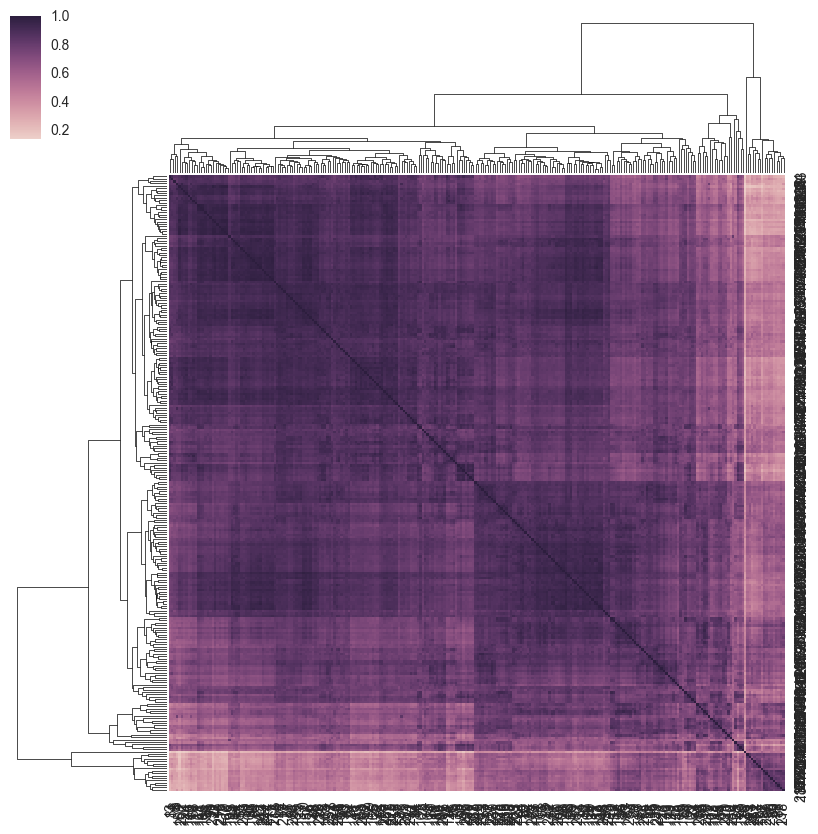

In [13]:
cmap = sns.cubehelix_palette(as_cmap=True)
(indices_t1, tumor_pcc) = pccClusterMap(tumor, 1, metric="euclidean", cmap=cmap) 

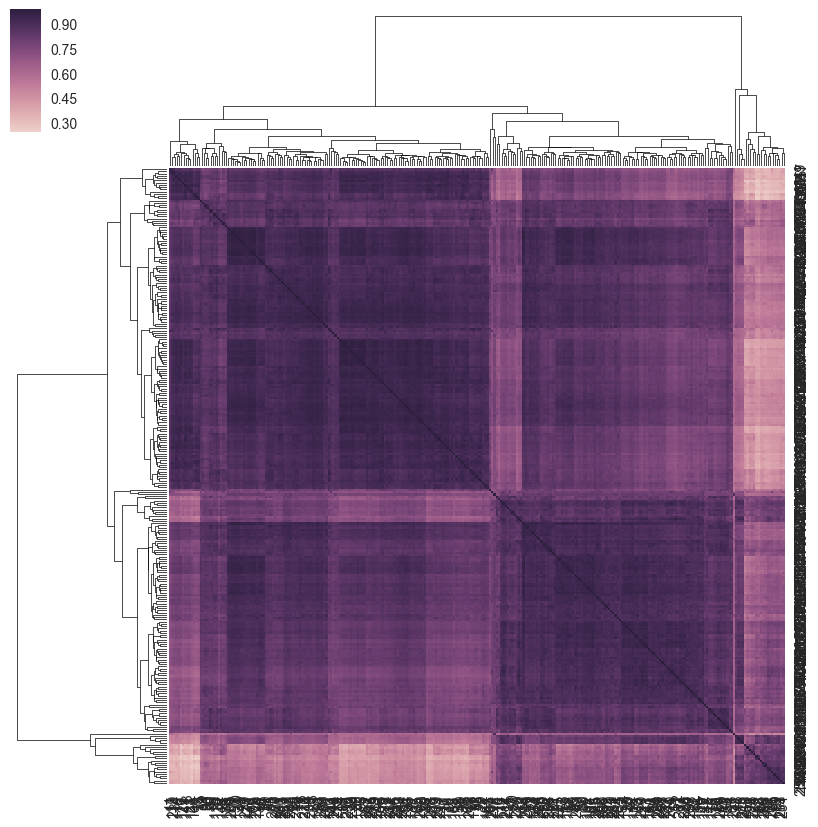

In [14]:
(indices_e1, exp_pcc) = pccClusterMap(exp, 1, "euclidean", cmap=cmap)

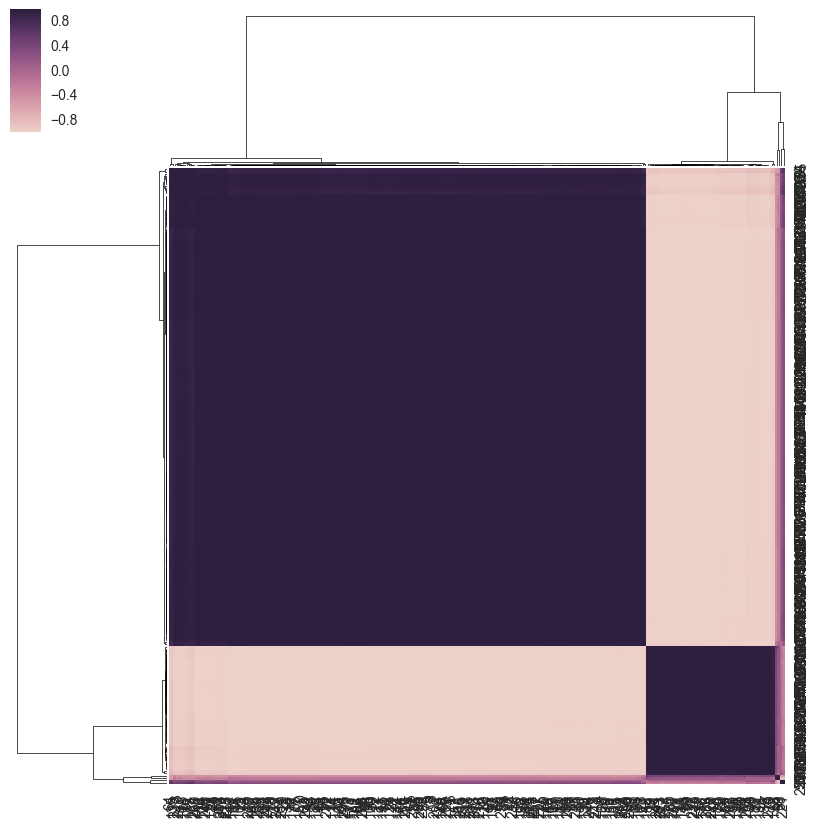

In [15]:
(indices_t5, tumor_pcc) = pccClusterMap(tumor, 5, metric="euclidean", cmap=cmap)

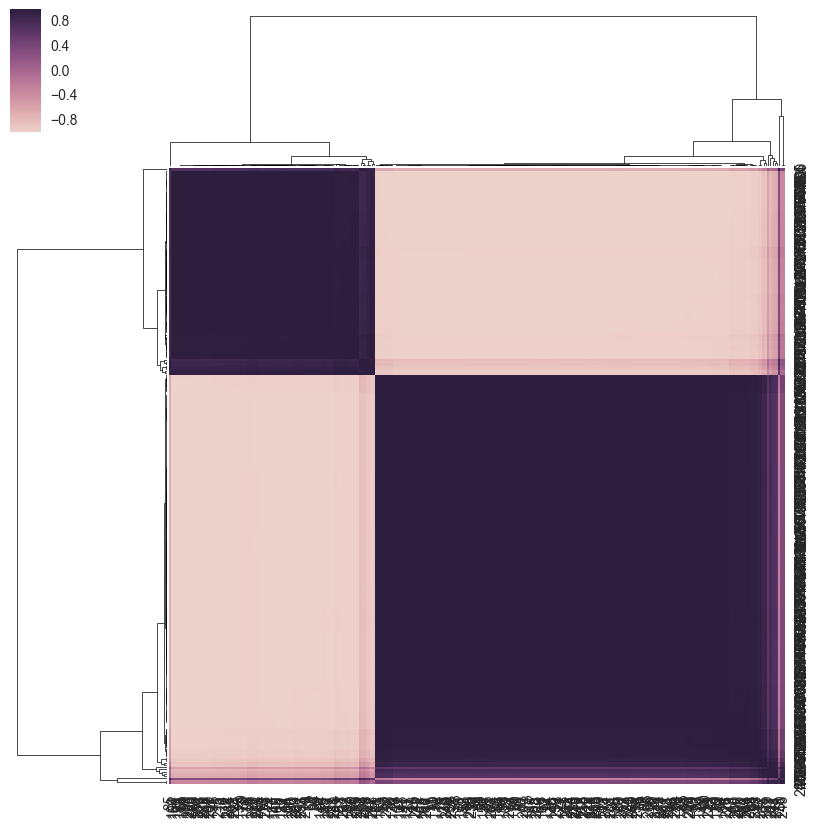

In [16]:
(indices_e5, exp_pcc) = pccClusterMap(exp, 5, "euclidean", cmap=cmap)

Interesting — the tumor data seems to classify our samples into 2 categories, whereas the expression data makes four clusters.

To satiate my curiosity, let's take a quick peek at the mutation data.

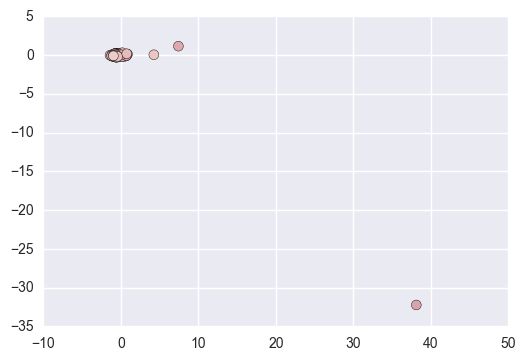

In [23]:
mut_pca = formatPCA(mut, n_components=3)
mut_pca_prog, mut_pca_noprog = getProgressedAndCensored(mut_pca)

ax = scatter(
    x=mut_pca_prog["E1"],
    y=mut_pca_prog["E2"],
    c=mut_pca_prog["Time"],
    s=50,
    cmap=cmap)

Ooh, this is the clearest example of structure so far. Let's look at the data associated with those outliers.

In [18]:
np.max(mut_pca)
mut_pca[mut_pca["E1"] > 10] # Samples 33, 95, 101, 200, 215, 249

E1            38.122806
E2            33.968960
E3            38.962930
Progressed     1.000000
Zeros          0.000000
dtype: float64

,E1,E2,E3,Progressed,Zeros
33,26.198013,2.892517,38.962930,False,0.0
95,31.218234,33.968960,-17.714922,False,0.0
101,38.122806,-32.249809,-14.862324,True,0.0
200,15.177484,1.067522,3.346869,False,0.0
215,14.250108,1.425331,-0.809941,False,0.0
249,16.525316,2.365490,2.405738,False,0.0


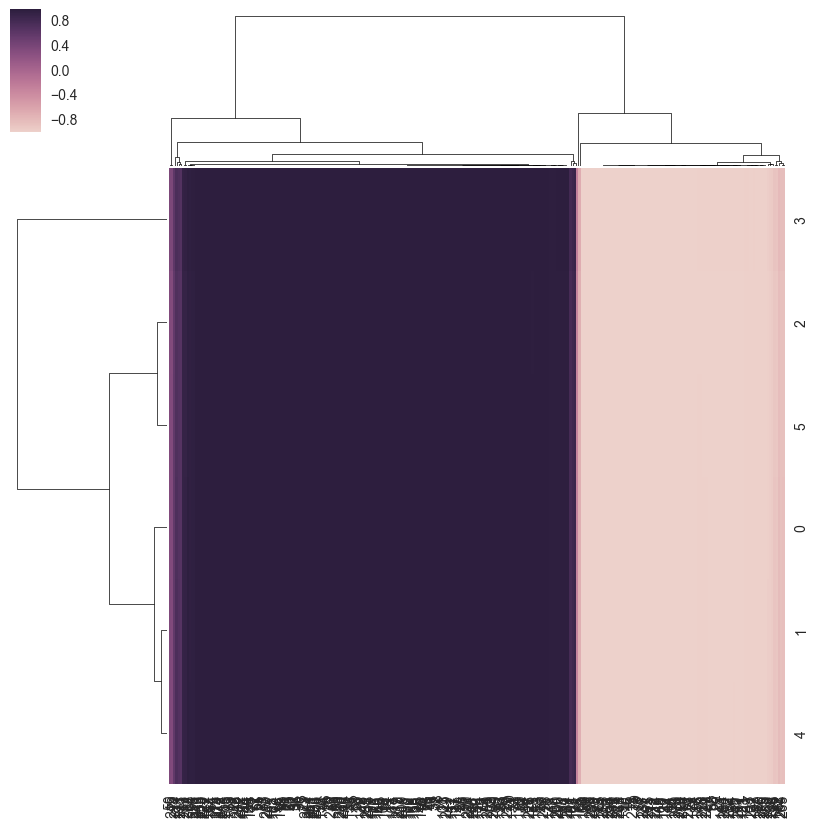

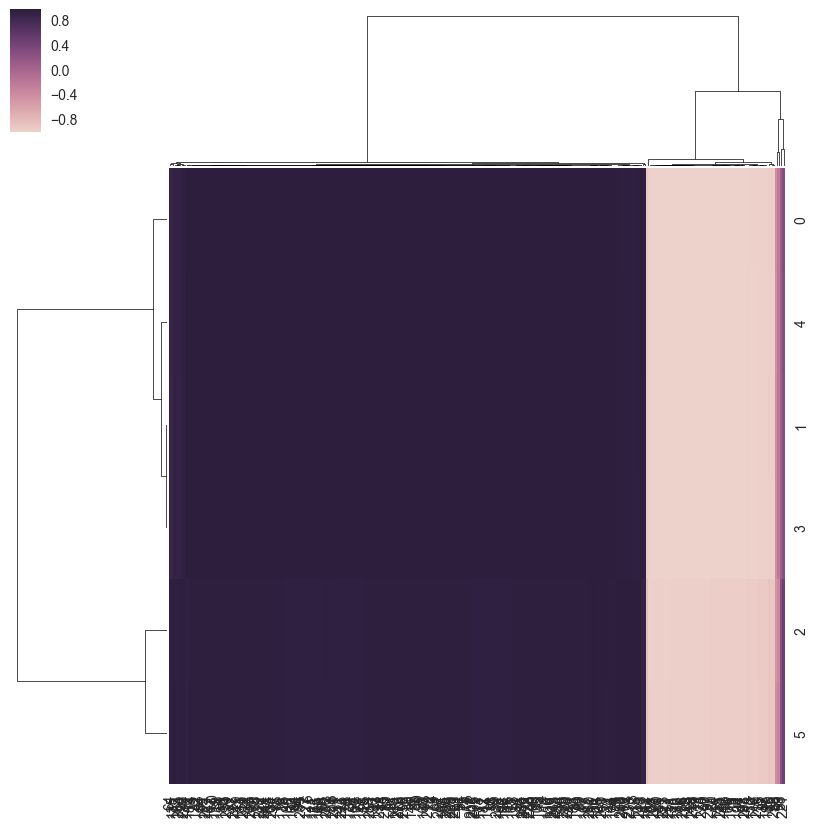

In [20]:
# Something in this cell keeps killing the kernel.
weird_samples = [33, 95, 101, 200, 215, 249]

#exp_pca.iloc[weird_samples]
#tumor_pca.iloc[weird_samples]

exp_pcc_weird = exp_pcc[weird_samples]
sns.clustermap(exp_pcc_weird, cmap=cmap)

tumor_pcc_weird = tumor_pcc[weird_samples]
sns.clustermap(tumor_pcc_weird, cmap=cmap)

#sns.clustermap(cop.iloc[weird_samples], cmap=cmap)

The tumor clustermap probably corresponds to progression/not progression. Although the expression clustermap seems to include a little more. Let's see how long it took patient 101 to progress.

In [22]:
labels.iloc[100]

TP     237
TO     347
P     True
Name: 101, dtype: object

Hmm. I am not entirely sure what to make of this. 237 isn't an extremely long or short amount of time. Maybe the cluster means something else — there has to be something significant about it. 

NEXT STEPS: 
- Try logistic regression/cox regression using iPcc'd data
- Then again with PCA'd mut data — abstract what you did so far a little bit more so this can become more streamlined, allowing you to make decisions about features and quickly test their effectiveness. Ideal:

new_data1

Model.classificationScore(new_data1)

Model.classificationValidationGraph(new_data1)

Model.coxRegressionScore(new_data2)

# Notes

## FPKM vs. TPM; RNA-seq Data

1/23/17: I've foolishly been playing around with the data for weeks now with just a surface-level understanding of FPKM. But this will make future statistics on this data more legitimate. Here are some notes:

* First, microarray data has a continuous distribution — we need a discrete probability distribution. Poisson or negative binomial distributions are typically used — to apply a generalized linear model (GLM), [5] suggests a modeling the data with a negative binomial distribution. 
    
    * "One aspect of this is that, because RNA-seq is a sampling procedure, there is a certain amount of “real estate” (the total number of all reads from the sequencing instrument) that the actual transcripts in the sequencing library have to “share.” This means that highly expressed transcripts will often make up a large amount of the sequencing library, and in a shallow sequencing experiment less expressed genes may not be represented in the final data even though they were present." - *RNA-seq Data Analysis: A Practical Approach (Chapman & Hall/CRC Mathematical and Computational Biology)* 
 

* We are assuming it is okay to treat the patients as biological replicates of each other.

**FPKM (Fragments Per Kilobase Million)**
* For paired end RNA-seq — just keeps track of fragments so we don't double count (otherwise it's the same as RPKM
    
* Normalize read counts for:
    
    1. Sequencing depth (greater sequencing depth leads to more reads for each gene; million)
    
        * i.e., for each gene in a sample, divide the read count by the sum of all the read counts for that sample
        
    2. The length of the gene (longer genes = more reads; kilobase)
        
        * next, divide by the size of the gene — done.
* "As a unit of measurement for an estimate, what FPKM really refers to is the expected number of fragments per kilboase[sic] of transcript per million reads."


This is how measurements used to be normalized. But recently, there's a superior normalization method:

**TPM (Transcripts Per Kilobase Million)**
    1. Normalize for length 
    2. Normalize for sequencing depth

* It is the same thing but in a different order. This actually matters — look at the youtube video [4] for an example. Imagine a pie chart, and your TPM/RPKM values represent how big each pie slice is. With TPM, each pie is the same size, so it's easy to compare (size of the pie = total number of reads). In RPKM, this pie is a different size for each sample, so it's harder to compare. RNA-seq is all about comparing the relative proportions of reads, so this metric makes more sense.

* "TPMs, which effectively normalize for the differences in composition of the transcripts in the denominator rather than simply dividing by the number of reads in the library, are considered more comparable between samples of different origins and composition but can still suffer some biases. These must be addressed with normalization techniques such as TMM." [1]

* Converting between FPKM and TPM: [2] [3] 

* FPKM and TPM still only find the *relative* measures of expression and cannot be compared between samples. There needs to be another degree of normalization to make the values absolute. This is a much harder task, but luckily, packages exist: 

    * Package to find TMM: https://bioconductor.org/packages/release/bioc/html/edgeR.html — This has a lot of other potentially useful functions to help with differential gene expression analysis! Although the practice persists, using RPKM data as input (by the way, you'd have to round it to an integer because edgeR expects read counts (ints)) is highly discouraged [5]. PROBLEM: I don't think we have the information (right away) to get TMM. Although, I wonder if we can leverage the mutation file as a way to estimate absolute copy number.


[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4728800/

[2] https://haroldpimentel.wordpress.com/2014/05/08/what-the-fpkm-a-review-rna-seq-expression-units/

[3] https://arxiv.org/pdf/1104.3889v2.pdf

[4] https://www.youtube.com/watch?v=TTUrtCY2k-w

[5] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4702322/pdf/12864_2015_Article_2353.pdf

[6] https://liorpachter.wordpress.com/tag/fpkm/ — blog of the author on [3]

Bias of FPKM: http://link.springer.com/article/10.1007/s12064-012-0162-3

https://support.bioconductor.org/p/69433/

**Note:** Remember to eliminate low read count genes to avoid having them get flagged as differentially expressed [5]; https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4702322/pdf/12864_2015_Article_2353.pdf supplementary materials goes over ways to find the expression threshold for RPKM and TMM values

## Seaborn

Seaborn Notes:

*** Style management ***

- There are two sets of functions that are used to manipulate matplotlib parameters (a e s t h e t i c s):
    1) axes_style(), set_style(); controls the style
    2) plotting_context(), set_context(); scales the plot
    * The first function inboth returns a dictionary of parameters, the second one sets the matplotlib defaults
- Use a with statement to temporarily set a figure style


*** Choosing color palettes ***
- color_palette() is the most important function you need for working with discrete color palettes
    - Interface to almost all of the possible ways to generate colors in seaborn
    - Used internally by any function that has a palette argument (sometimes color too, if >1 color is needed)
- Will accept any seaborn palette or matplotlib colormap
    - http://matplotlib.org/examples/color/colormaps_reference.html
    - Also any list of colors in a valid matplotlib format (RGB tuples, hex color codes, or HTML color names)
    - Always returns a list of RGB tuples
    - color_palette() with no args gives the current default color cycle

- set_palette takes the same arguments and sets the default color cycle for all plots
    - you can use color_palette and a with statement to make a temporary change

- There are 3 kinds of color palettes: qualitative, sequential, and diverging
    ** Qualitative **
    - sns.palplot() will plot color_palette() in the form of nice colored squares
    - The default color cycle is a set of six colors
        - When you want more, draw evenly-spaced colors using the "hls" color space, which is a simple transformation of RGB values
        - hls_palette(num_colors, l, s) lets you play with the lightness and saturation
        - But humans will perceive yellows and greens as brighter than say blues, even if the numerical brightness is the same
            - The husl system takes apparent brightness into account; husl_palette() for more control
        - But you can also just make your own list of colors and give it to color_palette (using HTML or Hex codes or something)
        - sns.xkcd_rgb (dict) has 954 colors that people named: https://xkcd.com/color/rgb/ and you can pass a list of names to xkcd_palette()
            - http://www.luminoso.com/colors/

    ** Sequential **
    - Used when the data range from low/uninteresting values to high or interesting ones.
    - The Color Brewer library has a good set of sequential palettes
        - choose_colorbrewer_palette() for interactive picking
    - You want subtle shifts in hue and large shifts in brightness and saturation to naturally draw the eye
        - Use the suffix _r to reverse the lightness ramp
        - Use _d for dark
        - cubehelix_palette() has a linear inc in brightness and some hue variation - good for greyscale printing
            - You can return it as a colormap object using as_cmap=True
            - Use choose_cubehelix_palette() for interactive color picking
    - For a much easier and simpler way to get custom sequential palettes, use light_palette() or dark_palette. You just seed it a single color (i.e., give it a string that is a color, like "blue" or "husl" or and xkcd color), and it'll make it all for you. You can also use choose_light_palette() or choose_dark_palette() for interactive picking
        - Reverse with reverse=True
    - as_cmap=True will make it into a colormap

    ** Diverging **
    - When the high and low are interesting; same rules, and Color Brewer has nice ones; choose_diverging_palette(); use diverging_palette() to make a custom colormap by passing in two hues (in degrees) and optionally two for lightness and saturation, and it works it out for you

    - set_palette() similar to the set_ aesthetics function - accepts same arguments as color_palette but changes the default parameters in matplotlib so that the palette is always used
    - with sns.color_palette() for temporary use

*** Visualizing the Distribution of a Dataset ***

- Often, the first step when you have data is to see how it is distributed
* Univariate
    - distplot(); plots a histogram and KDE, and if you want, a rug plot. You can set these to False as you desire.
        - A KDE is good to see the distribution
            - A KDE replaces each observation with a normal curve centered at the value, then summed to find the density, then normalized
        - The bw (bandwidth) parameter controls how tightly the estimation fits the data (analogous to bin size for hist)
    - You can also fit a parametric distribution to a dataset and see how closely it matches with the data
        - The scipy.stats function needs to be able to implement a fit() function; stats.nbinom won't work

* Bivariate
    - jointplot() creates a multipanel figure that shows the bivariate (i.e., joint), relationship b/t two variables AND the univariate distribution of each on separate axes.
    - Scatterplots are also a classic to visualize bivarate distribution. plt.scatter() is a thing, but the default jointplot() is a scatterplot
    - Hexbin is the bivariate version of a histogram; works best with a white background
    - You can generate a bivariate KDE as a contour plot by setting kind="kde" for jointplot()
    - jointplot() makes and manages it's own figure. Use kdeplot() if you want to put the contour map over an existing figure; modify the number of contour lines to make it more continuous-looking

    - jointplot() returns a JointGrid object to manage the figure. To have more options, just instantiate your own JointGrid: grid = sns.jointplot(x,y,data,kind,color), then you get access to class methods like plot_joint and ax_joint to add on more things to the same JointGrid object

    - If you have a lot of bivariate distributions in a dataset, you can use pairplot() to create a matrix of axes and it'll show the relationship for each pair, and on the diagonal, it'll show the univariate distribution
    - pairplot() returns a PairGrid object, which is kind of like JointPlot; you get access to class methods to keep customizing

*** Visualizing linear relationships ***
- When you have multiple quantitative variables, most of the time you want a way to relate them all together.
    - Seaborn is not meant for statistics, but rather, the regression is meant to highlight important details quickly
- Two main functions for linear regression: lmplot() and regplot()
    - In their simplest invocation, both functions draw a scatterplot between two variables, fit a regression model y ~ x, and plot the regression line + shade in a 95% confidence interval
    - regplot() accepts a variety of formats including simple numpy arrays, pandas Series objects, or as references to variables in a pandas DataFrame object passed to data.
    - lmplot() has data as a required parameter and the x and y variables must be specified as strings.
    - lmplot() is a subset of regplot()
    - You can regress on categorical variables, although the scatterplot given isn't ideal
    - lmplot() and regplot() can fit a polynomial regression model (order parameter)
    - Set robust=True to avoid outliers messing things up
    - When y is binary, use logistic=True to use a logistic regression
    - You can fit a nonparametric regression using a lowess smoother (lowess=True)
    - Use residplot() to see whether a simple regression would work or not - it fits and removes a simple linear regression and plots the residual values for observation; structure in the residuals implies that simple linear regression is inapppropriate
- What if you want to see how a relationship between two variables changes with regard to a third variable?
    - Use lmplot(), because it returns a FacetGrid
    - The best way to separate out a relationship is to plot both levels on the same axes and to use color to distinguish them:
        - sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips);
    - Use different markers and colors to make it more clear
    - Add another variable by drawing more than one facet, where each level of the variable appears in the rows/columns of the grid
        - sns.lmplot(x="total_bill", y="tip", hue="smoker", col="time", data=tips);
        - sns.lmplot(x="total_bill", y="tip", hue="smoker",
           col="time", row="sex", data=tips);
- regplot() is an axes level function (draws on specific axes) meaning you can make multipanel figures yourself (I think by the subplot() function), and if no axes are passed, it'll use the currently available axes (i.e., the defaults)
    - If you want to control the figure size you have to make a figure object yourself; f, ax = plt.subplots(figsize=(5,6))
- lmplot() is controlled through the FacetGrid interface using the variables size and shape, which apply to each facet of the plot but not the overall plot itself
- jointplot() can use regplot() to show the linear regression by passing kind="reg"
- using pairplot() with kind="reg" combines regplot() and PairGrid to show the linear relationship between variables in a dataset. This is different than lmplot() - it is not showing the relationship conditioned on two levels by a third variable, PairGrid is used to show multiple relationships between different pairings of the variables in a dataset
    - Like lmplot but not jointplot, conditioning on an additional, third categorical variable is is by the parameter hue
        sns.pairplot(tips, x_vars=["total_bill", "size"], y_vars=["tip"],
             hue="smoker", size=5, aspect=.8, kind="reg"); # makes two plots, with different X axes, same y, conditioned on the same var, smoker.

*** Plotting With Categorical Data ***

- Scatterplots and regression models can visualize the relationship between variables and how it changes across levels of additional categorical variables
- But if the main variables are categorical, scatterplot and regression won't work
- Three groups of plots:
    1) those that show each observation at each level of the categorical variable
        - swarmplot(), stripplot()
    2) those that show an abstract representation of each distribution of observations
        - boxplot(), violinplot()
    3) those that apply a statistical estimation to show a measure of central tendency and confidence interval
        - barplot(), pointplot()
- The above are all low-level functions (they plot directly onto matplotlib axes)
- Use the higher-level FacetGrid to apply a categorical plot across a grid of figure panels

Categorical Scatterplots
    - Categorical generalization of a scatterplot = stripplot. swamplot expands at dense points to make things more clear
    - Add a nested categorical variable with the hue parameter
    - Seaborn will infer the order of the categories; the pandas Categorical datatype can be used to set the default order of the categories (if the data is of type Categorical)

Distributions of Observations within Categories
- boxplot
- violinplot() combines a boxplot and a KDE
    - When the hue parameter only has two levels we can split the violinplot to use space better
- by calling violinplot() or boxplot then swarmplot (or I think stripplot too?) then you show each obs with a summary of the distribution

Statistical estimation within categories
- Rather than showing the distribution within each category you might want to show the central tendency of the values
- barplot operates on a full dataset and shows an arbitrary estimate, using the mean by default
    - when there are multiple observations in each category it also uses bootstrapping to compute a CI around the estimate and plots that using error bars
- sometimes you want to show the number of observations in each category and not just a statistic for a second variable
    - similar to a histogram over a categorical (instead of quantitative) data --- to do this use the countplot() function
- you can visualize the same thing with a pointplot, where the point is an estimate. so instead of three bar graphs, you have 3 points for each categorical variable (say 2, male+female) and lines connecting each pair

*** Plotting on Data-Aware Grids ***
- Useful if you want to look at the distribution of a variable or a relationship between multiple variables separately within subsets of your dataset
- Initialize FacetGrid with a dataframe and the names of the variables that will form the row, column, or hue dimensions of the grid; categorical or discrete only, then the data at each level of that variable will be used for a facet along the axis
    - The initializations will only draw an empty figure and axes

- Use facetgrid.map() and pass a plotting function and the names of the varialbes in the dataframe to plot to plot on the FacetGrid
- To make a relational plot, pass multiple variable names
    g = sns.FacetGrid(tips, col="sex", hue="smoker")
    g.map(plt.scatter, "total_bill", "tip", alpha=.7)
    - there are a few options to control the look of the grid that can be passed in the class constructor
- use size= and aspect= to control size
- gridspec_kwd{key: var} to specifically pass **kwds for a single facet panel
- you can use a seaborn color palettes (anything that can be passed to color_palette())
    - hue_kws{} to control things like marker shape
- multiple levels of one variable can be done using wrap= but you can't use row=
- Once you draw plots using FacetGrid.map() (can be done multiple times), you can adjust some aspects of the plot
    - there are methods for the FacetGrid object to do this; FacetGrid.set() is the most general, specialized methods like set_axis_labels() exists
    - you can also work with the underlying Figure and Axes objects
        - stored as member attributes as fig and axes
        - ax can directly access single axes if not using row or col faceting
        - for ax in g.axes.flat:

*** Mapping Custom Functions onto the Grid ***
1) Must plot onto teh currently active matplotlib axes (true of functions in the matplotlib.pyplot namespace)
    plt.gca will get a reference to the current axes if you want to work directly with the methods
2) it must accept the data it plots in positional arguments
    FacetGrid will pass a Series of data for each of the named positional arguments passed to FacetGrid.map()
3) Must accept color and label kwd arguments, and ideally, do something useful with them. Just catch a generic dictionary of **kwargs and pass it to the underlying plotting function

Custom univariate will obviously take in an x, bivariate x, y
    def quantile_plot(x, **kwargs):
        qntls, xr = stats.probplot(x, fit=False)
        plt.scatter(xr, qntls, **kwargs)

    def qqplot(x, y, **kwargs):
        _, xr = stats.probplot(x, fit=False)
        _, yr = stats.probplot(y, fit=False)
        plt.scatter(xr, yr, **kwargs)

Since plt.scatter accepts color and label and does the right thing with them, we can add a hue facet without difficulty

Sometimes, though, you’ll want to map a function that doesn’t work the way you expect with the color and label keyword arguments. In this case, you’ll want to explictly catch them and handle them in the logic of your custom function
    def hexbin(x, y, color, **kwargs):
        cmap = sns.light_palette(color, as_cmap=True) # explicitly handle
        plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(tips, hue="time", col="time", size=4)

*** Plotting pairwise relationships with PairGrid and pairplot() ***

* PairGrid also allows you to quickly draw a grid of small subplots using the same plot type to visualize data in each
In a PairGrid, each row/col is assigned toa  different variale, so the resulting plot shows each pairwise relationship in the dataset
    * sometimes called "scatterplot matrix" - but not limited to scatterplots

* The differences between FacetGrid and Pairgrid are important:
    FacetGrid: Each facet shows the SAME relationship conditions on different levels of other variables
    PairGrid: Each plot shows a DIFFERENT relationship (although the upper and lower triangles will have mirrored plots)
        Quick, high-level summary of interesting relationships in the dataset

* Basic usage is similar to FacetGrid:
1) Initialize
2) Pass plotting function to a map method
pairplot() is faster but you trade flexibility for that

* You can use map_diag to plot something specific on the diagonals and map_offdiag for the rest - but the axis ticks won't correspond to the new offdiag

* Commonly you color the observations by a separate categorical variable

* By default, every numeric column in the dataset is used, but you can focus on particular relationships if you want

* You can use a different function in the upper and lower triangles to emphasize different aspects of the relationship

* Configure aesthetics:
    g = sns.PairGrid(tips, hue="size", palette="GnBu_d")
    g.map(plt.scatter, s=50, edgecolor="white")

* pairplot() is good for quick views
* you can control the aesthetics with kwdargs and it returns a pairgrid instnace for further tweaking



## Nested Cross-Validation

    Data used to optimize the model should not be used to evaluate the model — namely, data used to feature select and optimize hyperparameters cannot be used to cross-validate the model.

    The solution is to use nested cross-validation (which is basically a combinatoric train-cross val-test scheme), or evaluate using the .632+ bootstrapping rule (or just use a proper cross-validation and test set that is entirely separate from training data, but this is unfeasible with a small sample number.

    References:
    http://www.pnas.org/content/99/10/6562.full.pdf
    http://jmlr.org/papers/volume11/cawley10a/cawley10a.pdf
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
    http://stats.stackexchange.com/questions/11602/training-with-the-full-dataset-after-cross-validation
    http://stats.stackexchange.com/questions/102842/what-to-do-after-nested-cross-validation -- has useful pseudocode
    http://stats.stackexchange.com/questions/257361/nested-cross-validation-for-feature-selection-and-hyperparameter-optimization -- my    question

    Pseudocode:
    # For each parameter set p; **parameter selection**
        # Split the set S' of N' available samples into num_samples' disjunct sets
        # **inner cross-validation**
        # for j=1 to num_splits'
                # Train the classifier on the training set S'' = S' \ S'_j
                # Calculate the test error on the parameter test set S'_j
            # Compute the inner CV test error
        # Select parameter set p with the minimum error

        # Train classifier with selected parameter set on S'
        # Calculate test error on S_i
    # Calculate outer CV test error

## Iterative Pearson Correlation Coefficient Idea (hierarchal clustering?)



    Iterative Pearson correlation coefficients: Generates Pearson correlation coefficients in the initial m samples x n features feature space to get an mxm matrix, which is then interpreted as m-samples m-features, finds the Pcc again, and iterates; reveals sample similarity hiding in higher-order correlation features, enlarge weak patterns underlying the raw dataset, and preserve the balanced independent relationship.
    http://nar.oxfordjournals.org/content/early/2013/06/12/nar.gkt343.full

    * Doesn't seem hard to implement and since all of the patients have myeloma, this might be a better way to find finer differences between the patients — ones that would lead to progression time differences.

    *  Maybe a NN can be made using this? dunno

    *  The accuracy of both k-means clustering and naive Bayes jumped like 15% when just using first-order coefficients.

    * Sample workflow: Select top 1000 features using F-test, then iPcc

    * "The reduced dimensionality allows rapid and accurate computation of the global optimum of many clustering and classification algorithms and thus improves accuracy." -- maybe this can be combined with

    * "However, iPcc is not an independent algorithm for disease class discovery or prediction. It provides an effective means to underpin the underlying patterns embedded within the gene expression data sets from the feature extraction perspective. Therefore, it can be used in combination with other clustering, classification, feature selection and feature extraction algorithms, as demonstrated in the results section."

    * Can't find a wrapper function for the iPcc, maybe I can make one and give it to scikit-learn

    * I think this might be called something else — "hierarchal clustering", or maybe we can use existing clustering algorithms iteratively with the Pearson correlation coefficient as the metric.

    Instead of approaching this problem as finding features to predict cancer (because they already all have cancer), perhaps approaching it from a cancer subtyping problem (Ren X, Wang Y, Wang J, Zhang XS. A unified computational model for revealing and predicting subtle subtypes of cancers. BMC Bioinformatics 2012;13:70.) might be fruitful, where the subtypes are how quickly they progress.


## Assorted Statistics Notes/References

https://en.wikipedia.org/wiki/Kurtosis
https://en.wikipedia.org/wiki/Normality_test
https://www.biostars.org/p/109104/
https://www.biostars.org/p/19012/
https://www.ma.utexas.edu/users/mks/384E/vartrans.pdf
See slide 7: https://scilifelab.github.io/courses/rnaseq/1604/slides/Differentiall_Expression_Analysis_Johan_Reimegard.pdf
